# Task 3
## Particles filter
### Robot description

A mobile robot is located in a square area 1000 meters long. Radio beacons are installed in the corners of the area. The robot can measure the distance to beacons. The measurement error is described by a normal distribution with zero mean and standard deviation $\sigma = 15$. It is known that the initial position of the robot is in the range of coordinates (0-100, 0-100). The initial orientation of the robot is $0 \pm 2$ degrees.

The robot functions as follows:

- Accepts from the operator the required angle of rotation and range of movement;
- Rotates to a given angle;
- Moves for a given distance;
- Measures the distance to beacons;
- Calculates position.

The robot rotates through a given angle with a normally distributed error with zero mean and standard deviation $\sigma_{\theta} = 2$. The robot moves to a given distance with a normally distributed error with zero mean and standard deviation $\sigma_{l} = 15$. It is required to build a particle filter to improve the localization accuracy of the robot.

### Task

- Set the initial position of the robot and standard deviations;
- Set at least 5 commands to move the robot;
- Build the trajectory of the robot's movement, taking into account errors;
- Build a particle filter for the robot;
- Build a trajectory of the robot's movement, the position of the particles and an estimate of the position of the robot after the execution of each of the commands;
- Repeat the previous steps for three different initial positions, standard deviations, number of particles and motion paths.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

### Set the initial position of the robot and standard deviation

In [2]:
initial_position = np.array([0, 0])
standard_deviations = np.array([math.radians(2), 15])


### Commands to move robot

In [3]:
commands = [
    {
        "rotation": np.pi/4,
        "movement": 250,
    },
    {
        "rotation": np.pi/2,
        "movement": 500,
    },
    {
        "rotation": np.pi/4,
        "movement": 1000,
    },
    {
        "rotation": np.pi/2,
        "movement": 250,
    },
    {
        "rotation": -np.pi/4,
        "movement": 250,
    }
]

rotx = [np.pi/4, np.pi/2, np.pi/4, np.pi/2, -np.pi/4,]


### Build trajectory to move robot taking into account errors

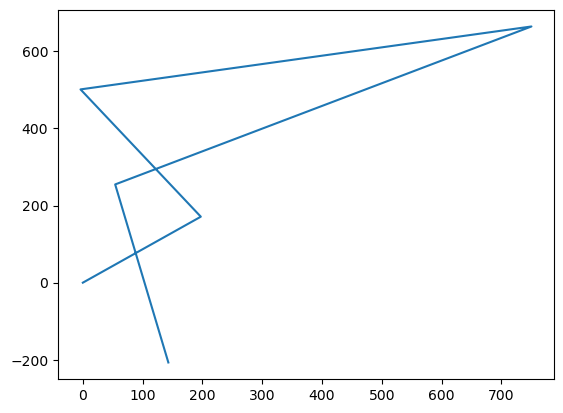

In [32]:
X = [initial_position[1]]
Y = [initial_position[1]]
ang = []
for command in commands:
    angle = command["rotation"] + initial_position[0] + + random.gauss(0, standard_deviations[0])
    distancex = initial_position[1] + command["movement"] * np.cos(angle) + np.random.normal(0, standard_deviations[1])
    distancey = initial_position[1] + command["movement"] * np.sin(angle) + np.random.normal(0, standard_deviations[1])
    #new_position = initial_position + np.array([angle, distance]) * np.array([0, 1])
    #trajectory.append(new_position)
    X.append(distancex)
    Y.append(distancey)
    ang.append(angle)

plt.plot(X, Y)
plt.show()

### Trajectory without noise

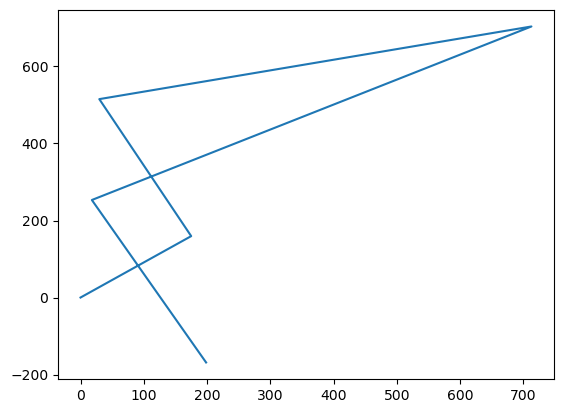

In [6]:
Xn = [initial_position[1]]
Yn = [initial_position[1]]
for command in commands:
    angle = command["rotation"] + initial_position[0] + + random.gauss(0, standard_deviations[0])
    distancex = initial_position[1] + command["movement"] * np.cos(angle) + np.random.normal(0, standard_deviations[1])
    distancey = initial_position[1] + command["movement"] * np.sin(angle) + np.random.normal(0, standard_deviations[1])
    #new_position = initial_position + np.array([angle, distance]) * np.array([0, 1])
    #trajectory.append(new_position)
    Xn.append(distancex)
    Yn.append(distancey)

plt.plot(Xn, Yn)
plt.show()

### Ideal

In [7]:
Xid = [initial_position[1]]
Yid = [initial_position[1]]
for command in commands:
    angle = command["rotation"] 
    dx = command["movement"] * np.cos(angle) 
    dy = command["movement"] * np.sin(angle)
    #new_position = initial_position + np.array([angle, distance]) * np.array([0, 1])
    #trajectory.append(new_position)
    Xid.append(dx)
    Yid.append(dy)

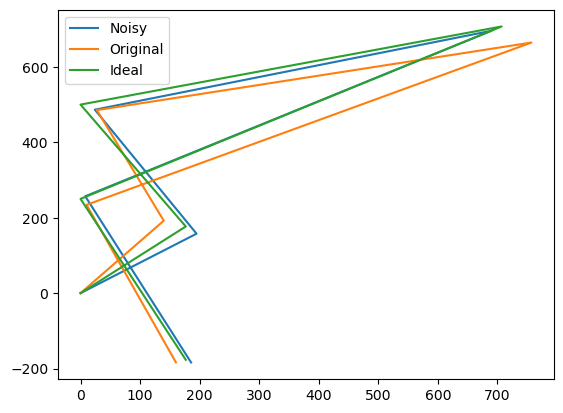

In [31]:
plt.plot(Xn, Yn)
plt.plot(X, Y)
plt.plot(Xid, Yid)
plt.legend(["Noisy", "Original", "Ideal"])
plt.show()

### Build a particle filter for the robot

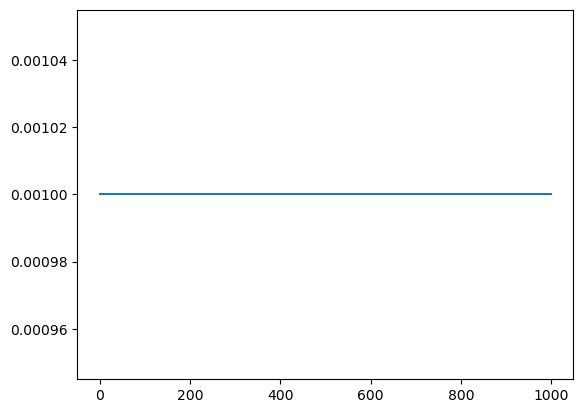

In [10]:
number_of_particles = 1000
particles = np.zeros((number_of_particles, 3))
weights = np.ones(number_of_particles) / number_of_particles

plt.plot(range(number_of_particles), weights)

In [21]:
def movement(initial_positionX, initial_positionY, initial_angle, command):
    new_angle = command["rotation"] + initial_angle  + random.gauss(0, standard_deviations[0])
    newX = initial_positionX + command["movement"] * np.cos(new_angle) - np.random.normal(0, standard_deviations[1])
    newY = initial_positionY + command["movement"] * np.sin(new_angle) - np.random.normal(0, standard_deviations[1])
    return newX, newX, new_angle


In [ ]:
robotX = np.random.randint(0, 500)
robotY = np.random.randint(0, 500)
robot_angle = 0
X = [robotX]
Y = [robotY]
angle = [robot_angle]

robotX, robotY, robot_angle = movement(robotX, robotY, robot_angle, commands[0])
for i in range(number_of_particles):
    particles[i, 0], particles[i, 1], particles[i, 2] = movement(particles[i][0], particles[i][1], particles[i][2], commands[0])


### Build a trajectory of the robot's movement, the position of the particles and an estimate of the position of the robot after the execution of each of the commands

In [30]:
u1 = [0, 100]
u2  = [100, 0]
u3 = [100, 100]
u4 = [0, 100]
def measurement(robotX, robotY, errorX, errorY):
    posX = robotX + errorX
    posY = robotY + errorY
    d1 = np.sqrt((u1[0] - posX)**2 + (u1[1] - posX)**2)
    d2 = np.sqrt((u2[0] - posX)**2 + (u2[1] - posX)**2)
    d3 = np.sqrt((u3[0] - posX)**2 + (u3[1] - posX)**2)
    d4 = np.sqrt((u4[0] - posX)**2 + (u4[1] - posX)**2)
    return [d1, d2, d3, d4]



In [36]:
def probability(distance, meas_distance):
    return 1 / np.sqrt(2 * np.pi * standard_deviations[1]) * np.exp( - (distance - meas_distance)**2 / standard_deviations[1])


In [37]:
def weight_cal(particles, weights, robot_measurements):
    for i in range(number_of_particles):
        particle_dist = measurement(particles[i, 0], particles[i, 1], 0, 0)
        weights[i] = probability(particle_dist[0], robot_measurements[0]) * probability(particle_dist[1], robot_measurements[1]) * probability(particle_dist[2], robot_measurements[2]) * probability(particle_dist[3], robot_measurements[3])
    weights = weights / np.sum(weights)
    return weights

### Resampling

In [38]:
def resample(particles, weights):
    newParticles = []
    newWeights = []
    N = len(particles)
    index = np.random.randint(0, N)
    betta = 0
    for i in range(N):
        betta = betta + np.random.uniform(0, 2*max(weights))
        while betta > weights[index]:
            betta = betta - weights[index]
            index = (index + 1)%N # index changes in a loop from 0 to N
        newParticles.append(particles[index])
        newWeights.append(weights[index])
    newWeights = newWeights / np.sum(newWeights)
    
    return np.array(newParticles), newWeights

### Position Estimation

In [39]:
def estimation(particles, weights):
    estimateX = 0
    estimateY = 0
    for i in range(len(particles)):
        estimateX = estimateX + particles[i, 0] * weights[i]
        estimateY = estimateX + particles[i, 1] * weights[i]
    return estimateX, estimateY

### Complete Example

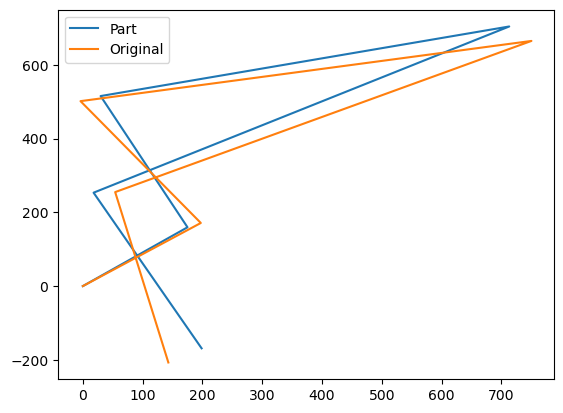

In [41]:
initial_position = np.array([0, 0])
standard_deviations = np.array([math.radians(2), 15])
robotX = np.random.randint(0, 1000)
robotY = np.random.randint(0, 1000)
robot_angle = 0
estX = 0
estY = 0

standard_deviation_angle = standard_deviations[0]
number_of_particles = 2000
particles = np.zeros((number_of_particles, 3))
#commands = [(np.pi/4, 100), (np.pi/2, 50), (-np.pi/4, 75), (0, 100), (np.pi/4, 50)]


for i in range(number_of_particles):
    particles[i][0] = np.random.normal(0, standard_deviations[1])
    particles[i][1] = np.random.normal(0, standard_deviations[1])
    particles[i][2] = np.random.normal(0, standard_deviations[0])

weights = np.ones(number_of_particles, dtype='float64') / number_of_particles
X = [robotX]
Y = [robotY]
X_est = [estX]
Y_est = [estY]
for command in commands:
    robotX, robotY, robot_angle = movement(robotX, robotY, robot_angle, command)
    X.append(robotX)
    Y.append(robotX)

    for i in range(number_of_particles):
        particles[i, 0], particles[i, 1], particles[i, 2] = movement(particles[i][0], particles[i][1], particles[i][2], commands[0])

    robot_measurement = measurement(robotX, robotY, np.random.normal(0, standard_deviations[1]), np.random.normal(0, standard_deviations[1]))
       
    weights = weight_cal(particles, weights, robot_measurement)
    

    particles, weights = resample(particles, weights)

    estX, estY = estimation(particles, weights)
    X_est.append(estX)
    Y_est.append(estY)

plt.plot(X, Y)
plt.plot(X_est, Y_est)
plt.legend(["Part", "Original"])
plt.show()